# Feature Adversaries Attack in TensorFlow v2

Before diving into the attack, let's first prepare a classification model. We utilize a script from the `examples` folders.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist

# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Cast to np.float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Step 2: Create the model

model = Sequential()
model.add(Conv2D(filters=4, kernel_size=5, activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), padding="valid", data_format=None))
model.add(Conv2D(filters=10, kernel_size=5, activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), padding="valid", data_format=None))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(10))

# Step 2a: Define the loss function and optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Step 3: Create the ART classifier

classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=10,
    input_shape=(28, 28, 1),
    clip_values=(0, 1),
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 96.77%


---

## PGD variant of Feature Adversaries


In [2]:
# Step 5: prepare a batch of source and guide images
valid = np.argmax(y_test, axis=1)[:100] != np.argmax(y_test, axis=1)[100:200]
source = x_test[:100][valid][:32]
guide = x_test[100:200][valid][:32]

In [3]:
# Step 6: Generate adversarial test examples
attack = FeatureAdversariesTensorFlowV2(
    classifier,
    layer=-2,
    delta=45/255,
    optimizer=None,
    step_size=1/255,
    max_iter=100,
)
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

dim = tuple(range(1, len(source.shape)))
pert = np.mean(np.amax(np.abs(source - x_test_adv), axis=dim))
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Feature Adversaries TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test batch: 0.0%
Average perturbation: 0.17647060751914978%


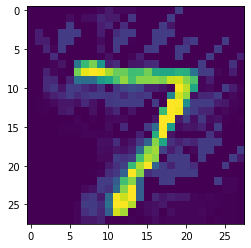

In [4]:
# Step 8: Inspect results

# orig 7, guide 6
plt.imshow(x_test_adv[0,...].squeeze())

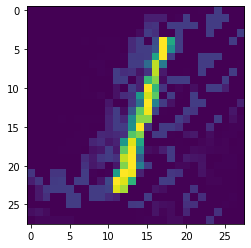

In [5]:
# orig 1, guide 5
plt.imshow(x_test_adv[2,...].squeeze())

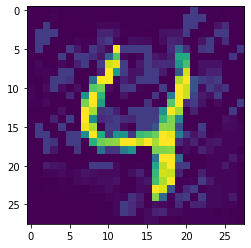

In [6]:
# orig 4, guide 9
plt.imshow(x_test_adv[4,...].squeeze())

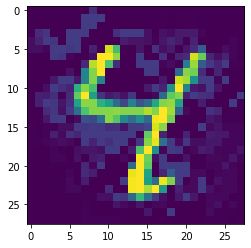

In [7]:
# orig 4, guide 2
plt.imshow(x_test_adv[6,...].squeeze())

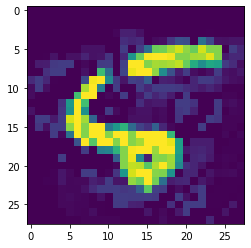

In [8]:
# orig 5, guide 9
plt.imshow(x_test_adv[8,...].squeeze())

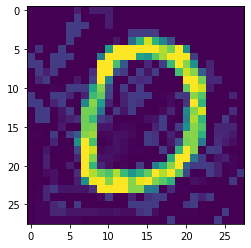

In [9]:
# orig 0, guide 8
plt.imshow(x_test_adv[10,...].squeeze())


## Unconstrained variant of Feature Adversaries

This variant approximates the original hard constraint problem of the paper. Any available TensorFlow v2 optimizer can be used. We will use Adam as a good default one.


In [10]:
# Step 6: Generate adversarial test examples
attack = FeatureAdversariesTensorFlowV2(
    classifier,
    layer=-2,
    delta=45/255,
    optimizer=tf.keras.optimizers.Adam,
    optimizer_kwargs={"learning_rate": 0.01},
    lambda_=1.0,
    max_iter=100,
    random_start=True,
)
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

dim = tuple(range(1, len(source.shape)))
pert = np.mean(np.amax(np.abs(source - x_test_adv), axis=dim))
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Feature Adversaries TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test batch: 0.0%
Average perturbation: 0.17647060751914978%


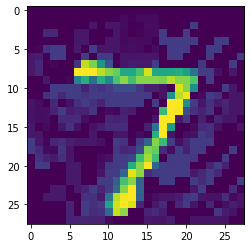

In [11]:
# Step 8: Inspect results

# orig 7, guide 6
plt.imshow(x_test_adv[0,...].squeeze())

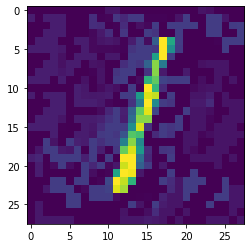

In [12]:
# orig 1, guide 5
plt.imshow(x_test_adv[2,...].squeeze())

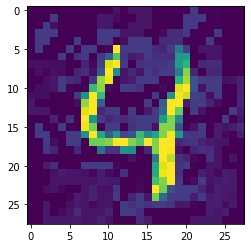

In [13]:
# orig 4, guide 9
plt.imshow(x_test_adv[4,...].squeeze())

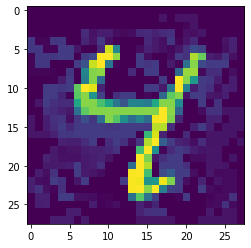

In [14]:
# orig 4, guide 2
plt.imshow(x_test_adv[6,...].squeeze())

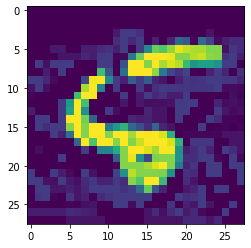

In [15]:
# orig 5, guide 9
plt.imshow(x_test_adv[8,...].squeeze())

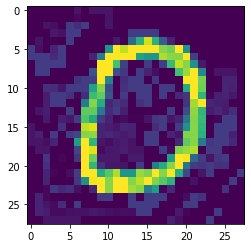

In [16]:
# orig 0, guide 8
plt.imshow(x_test_adv[10,...].squeeze())